# MW-M31 Post-Merger Remnant: rotations

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Stellar-remnant" data-toc-modified-id="Stellar-remnant-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Stellar remnant</a></span><ul class="toc-item"><li><span><a href="#Oriented-views" data-toc-modified-id="Oriented-views-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Oriented views</a></span></li><li><span><a href="#Phase-diagrams" data-toc-modified-id="Phase-diagrams-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Phase diagrams</a></span></li></ul></li><li><span><a href="#Specific-angular-momentum" data-toc-modified-id="Specific-angular-momentum-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Specific angular momentum</a></span><ul class="toc-item"><li><span><a href="#Subgroup-$h$" data-toc-modified-id="Subgroup-$h$-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Subgroup $h$</a></span></li><li><span><a href="#Angular-momentum-by-radius" data-toc-modified-id="Angular-momentum-by-radius-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Angular momentum by radius</a></span></li><li><span><a href="#Halo-angular-momentum" data-toc-modified-id="Halo-angular-momentum-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Halo angular momentum</a></span><ul class="toc-item"><li><span><a href="#Halo-time-course" data-toc-modified-id="Halo-time-course-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Halo time course</a></span></li></ul></li><li><span><a href="#Spin-parameter-$\lambda$" data-toc-modified-id="Spin-parameter-$\lambda$-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Spin parameter $\lambda$</a></span></li></ul></li><li><span><a href="#Velocity-dispersion" data-toc-modified-id="Velocity-dispersion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Velocity dispersion</a></span></li></ul></div>

## Setup

In [1]:
# import modules
import numpy as np
from numpy.linalg import norm
from scipy.optimize import curve_fit
import pandas as pd
import astropy.units as u
from astropy.constants import G
from astropy.cosmology import Planck15, z_at_value

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mpl_scatter_density
from matplotlib import rcParams
# 
# Make the norm object to define the image stretch
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
im_norm = ImageNormalize(vmin=0., vmax=1000, stretch=LogStretch())

%matplotlib inline

In [2]:
# my modules
from galaxy.galaxy import Galaxy
from galaxy.centerofmass import CenterOfMass
from galaxy.massprofile import MassProfile
from galaxy.plots import Plots
from galaxy.timecourse import TimeCourse
from galaxy.utilities import find_nearest

from galaxy.remnant import Remnant

In [3]:
tc = TimeCourse()
p = Plots()

## Stellar remnant

In [4]:
# Just luminous particles: ptype defaults to (2,3)
remnant = Remnant(usesql=True)

In [5]:
remnant.data, remnant.data.shape

(array([('M31', 2, 2.000e-05, 196.939, 24.1967, 139.881, 260.831  ,  -85.0969, -26.0921),
        ('M31', 2, 2.000e-05, 189.087, 20.2326, 146.165,  18.4025 ,   23.0247,  32.5107),
        ('M31', 2, 2.000e-05, 206.619, 19.0085, 122.444, -62.8166 , -162.355 , 181.913 ),
        ...,
        ('MW ', 3, 2.001e-05, 171.059, 13.8007, 128.251,  42.7172 ,  -34.8959,  64.3355),
        ('MW ', 3, 2.001e-05, 188.957, 23.4792, 147.111, 257.351  ,  -53.4361, -95.3574),
        ('MW ', 3, 2.001e-05, 189.534, 21.7683, 148.253,  -2.96004,   82.9176,  26.7174)],
       dtype=[('galname', '<U3'), ('type', 'u1'), ('m', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4')]),
 (1120000,))

In [6]:
def get_counts(remnant):
    df = pd.DataFrame()
    df['gal'] = remnant.data['galname']
    df['type'] = remnant.data['type']

    # create some better column names
    types = {1: 'Halo', 2: 'Disk', 3: 'Bulge'}
    df['typename'] = df['type'].map(types)

    # get pandas to do most of the work
    df_piv = pd.pivot_table(df, values='type',
                            index='gal', columns='typename',
                            aggfunc='count', fill_value=0, margins=True)
    return df_piv

In [7]:
counts = get_counts(remnant) / 1000
counts

typename,Bulge,Disk,All
gal,,,
M31,95.0,600.0,695.0
MW,50.0,375.0,425.0
All,145.0,975.0,1120.0


In [8]:
print(counts.to_latex())

\begin{tabular}{lrrr}
\toprule
typename &  Bulge &   Disk &     All \\
gal &        &        &         \\
\midrule
M31 &   95.0 &  600.0 &   695.0 \\
MW  &   50.0 &  375.0 &   425.0 \\
All &  145.0 &  975.0 &  1120.0 \\
\bottomrule
\end{tabular}



### Oriented views

In [9]:
com = CenterOfMass(remnant, ptype=None)
L, pos, v = com.angular_momentum()
L, norm(L)

(array([ 1.6242846e+08, -7.1358522e+08, -4.9119174e+08], dtype=float32),
 881394500.0)

In [10]:
m = remnant.data['m']
xyz_rot, vxyz_rot = com.rotate_frame(r_lim=150)
xyz_rot.shape

(3, 1116664)

In [11]:
r = norm(xyz_rot, axis=0)
r.shape, r.min(), r.max(), r.mean()

((1116664,), 0.0308764436097017, 149.99401659025494, 16.977322840926107)

In [12]:
lim = 10 # axes +/- lim
fontsize = 22 # for labels

central = np.where((np.abs(xyz_rot[0])<lim) & (np.abs(xyz_rot[1])<lim) & (np.abs(xyz_rot[2])<lim))
x, y, z = (xyz_rot.T[central]).T
vx, vy, vz = (vxyz_rot.T[central]).T

/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


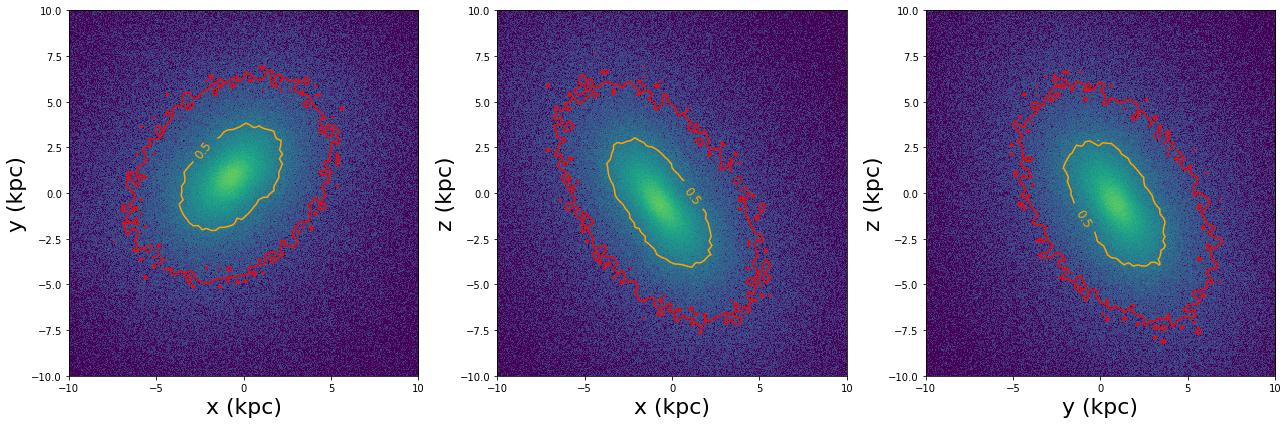

In [13]:
fig = plt.figure(figsize=(18,6))

# left plot x-y
ax0 = fig.add_subplot(1, 3, 1, projection='scatter_density')
ax0.scatter_density(x, y, norm=im_norm)

ax0.set_xlim(-lim, lim)
ax0.set_ylim(-lim, lim)

ax0.set_xlabel('x (kpc)', fontsize=fontsize)
ax0.set_ylabel('y (kpc)', fontsize=fontsize)

level_vals = [0.5, 0.75]
colors = ['red','orange', 'yellow', 'orange', 'yellow']

p.density_contour(x, y, 80, 80, level_vals, ax=ax0, colors=colors)

# mid plot x-z
ax1 = fig.add_subplot(1, 3, 2, projection='scatter_density')
ax1.scatter_density(x, z, norm=im_norm)

ax1.set_xlim(-lim, lim)
ax1.set_ylim(-lim, lim)

ax1.set_xlabel('x (kpc)', fontsize=fontsize)
ax1.set_ylabel('z (kpc)', fontsize=fontsize)

p.density_contour(x, z, 80, 80, level_vals, ax=ax1, colors=colors)

# right plot y-z
ax2 = fig.add_subplot(1, 3, 3, projection='scatter_density')
ax2.scatter_density(y, z, norm=im_norm)

ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)

ax2.set_xlabel('y (kpc)', fontsize=fontsize)
ax2.set_ylabel('z (kpc)', fontsize=fontsize);

p.density_contour(y, z, 80, 80, level_vals, ax=ax2, colors=colors)

#adjust tick label font size
label_size = 16
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
plt.tight_layout()
plt.savefig('remnant_shape.pdf', rasterized=True, dpi=350);

In [14]:
def disp_by_radius(x, vy, xbins, binwidth=None):
    
    if binwidth is None:
        binwidth = x[1] - x[0]
    
    means = np.zeros(len(xbins))
    sigmas = np.zeros(len(xbins))
    
    for i, xi in enumerate(xbins):
        filt = np.where((x > xi - binwidth/2) & (x < xi + binwidth/2))
        vel = vy[filt]
        if len(vel) > 0:
            means[i] = np.mean(vel)
            sigmas[i] = np.std(vel - means[i])
        # else remain zero
    
    return means, sigmas

In [15]:
xbins = np.linspace(-39, 39, 100)
means, sigmas = disp_by_radius(xyz_rot[1], vxyz_rot[0], xbins)
vmax = (np.max(means) - np.min(means)) / 2
sigma_central = np.max(sigmas)
vmax, sigma_central, vmax/sigma_central

(66.71753957023628, 165.96680940433563, 0.40199326485632486)

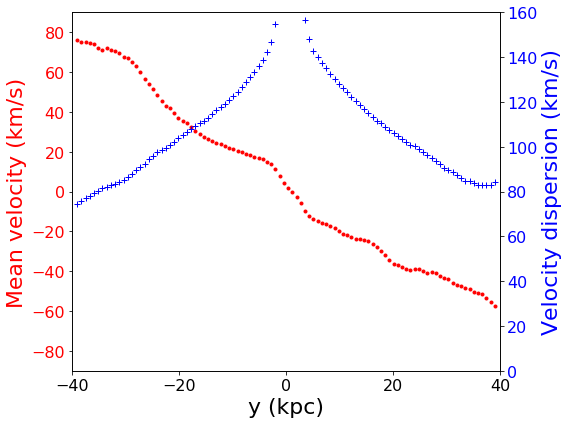

In [16]:
fig, ax1 = plt.subplots(figsize=(8,6))

color = 'red'
ax1.plot(xbins, means, 'r.', label='radial velocity')
ax1.set_xlabel('y (kpc)', fontsize=fontsize)
ax1.set_ylabel('Mean velocity (km/s)', color=color, fontsize=fontsize)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(-40,40)
ax1.set_ylim(-90,90)

ax2 = ax1.twinx()  # shares the same x-axis as ax1

color = 'blue'
ax2.plot(xbins, sigmas, 'b+', label='velocity dispersion')
ax2.set_ylabel('Velocity dispersion (km/s)', color=color, fontsize=fontsize)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,160)

# plt.legend()

#adjust tick label font size
label_size = 18
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

fig.tight_layout()  
plt.savefig('remnant_stellar_disp_y.pdf', rasterized=True, dpi=350);

In [17]:
means2, sigmas2 = disp_by_radius(xyz_rot[2], vxyz_rot[0], xbins)
vmax2 = (np.max(means2) - np.min(means2)) / 2
vmax2

0.0

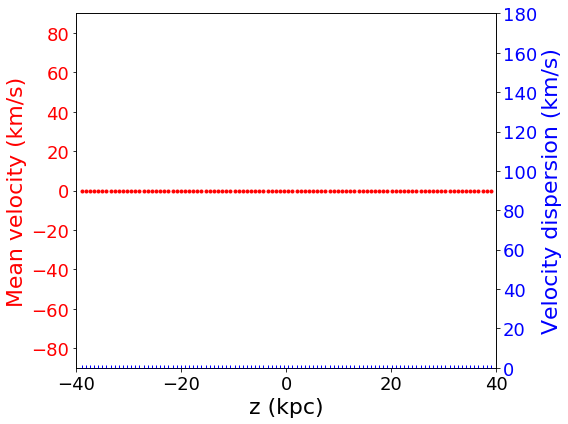

In [18]:
fig, ax1 = plt.subplots(figsize=(8,6))

color = 'red'
ax1.plot(xbins, means2, 'r.', label='radial velocity')
ax1.set_xlabel('z (kpc)', fontsize=fontsize)
ax1.set_ylabel('Mean velocity (km/s)', color=color, fontsize=fontsize)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(-40,40)
ax1.set_ylim(-90,90)

ax2 = ax1.twinx()  # shares the same x-axis as ax1

color = 'blue'
ax2.plot(xbins, sigmas2, 'b+', label='velocity dispersion')
ax2.set_ylabel('Velocity dispersion (km/s)', color=color, fontsize=fontsize)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,180)

# plt.legend()

#adjust tick label font size
label_size = 18
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

fig.tight_layout()  
plt.savefig('remnant_stellar_disp_z.pdf', rasterized=True, dpi=350);

In [19]:
epsilon = 0.5
v_sigma = np.pi/4 * np.sqrt(2 * ((1-epsilon)**(-0.9) - 1))
v_sigma

1.0336663290308634

### Phase diagrams

/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


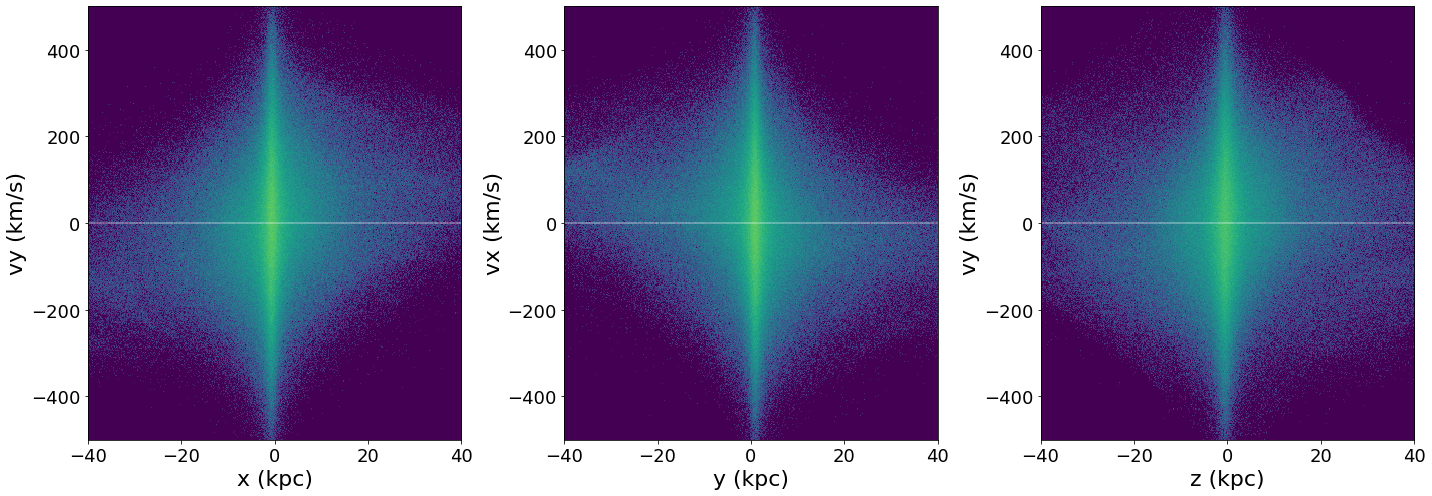

In [20]:
fig = plt.figure(figsize=(20,7))

lim = 40 # distance axes +/- lim
vlim = 500
fontsize = 22 # for labels

# left plot x-vy
ax0 = fig.add_subplot(1, 3, 1, projection='scatter_density')
ax0.scatter_density(xyz_rot[0], vxyz_rot[1], norm=im_norm)
ax0.plot((-lim, lim), (0,0), 'w-', alpha=0.4)

ax0.set_xlim(-lim, lim)
ax0.set_ylim(-vlim, vlim)

ax0.set_xlabel('x (kpc)', fontsize=fontsize)
ax0.set_ylabel('vy (km/s)', fontsize=fontsize)

# mid plot x-vz
ax1 = fig.add_subplot(1, 3, 2, projection='scatter_density')
ax1.scatter_density(xyz_rot[1], vxyz_rot[0], norm=im_norm)
ax1.plot((-lim, lim), (0,0), 'w-', alpha=0.4)

ax1.set_xlim(-lim, lim)
ax1.set_ylim(-vlim, vlim)

ax1.set_xlabel('y (kpc)', fontsize=fontsize)
ax1.set_ylabel('vx (km/s)', fontsize=fontsize);

# right plot z-vy
ax2 = fig.add_subplot(1, 3, 3, projection='scatter_density')
ax2.scatter_density(xyz_rot[2], vxyz_rot[1], norm=im_norm)
ax2.plot((-lim, lim), (0,0), 'w-', alpha=0.4)

ax2.set_xlim(-lim, lim)
ax2.set_ylim(-vlim, vlim)

ax2.set_xlabel('z (kpc)', fontsize=fontsize)
ax2.set_ylabel('vy (km/s)', fontsize=fontsize);

plt.tight_layout()
plt.savefig('remnant_phase.pdf', rasterized=True, dpi=350);

/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


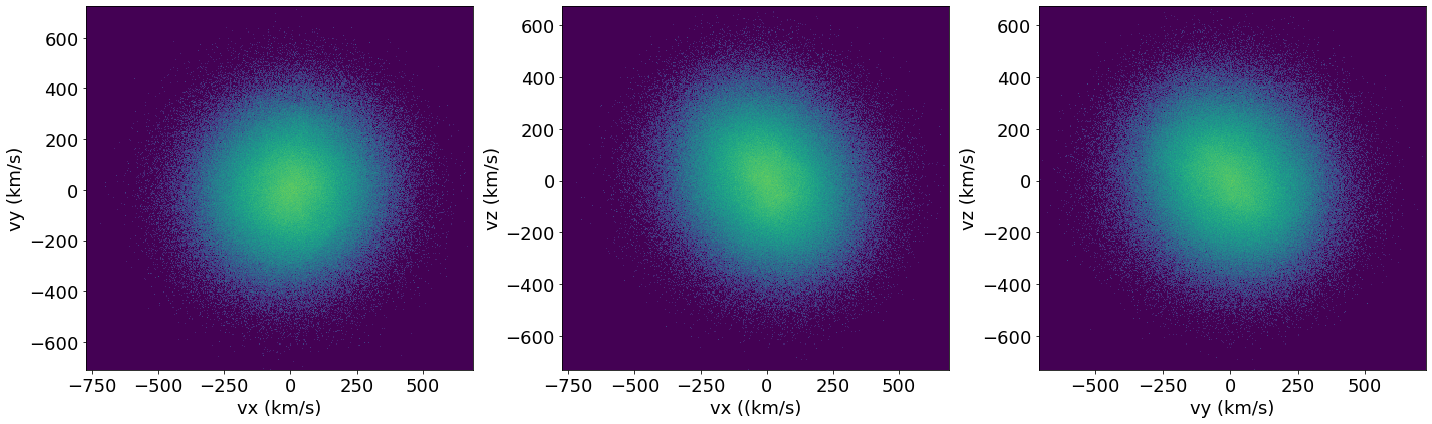

In [21]:
fig = plt.figure(figsize=(20,6))

lim = 80 # axes +/- lim
fontsize = 18 # for labels

# left plot x-vy
ax0 = fig.add_subplot(1, 3, 1, projection='scatter_density')
ax0.scatter_density(vxyz_rot[0], vxyz_rot[1], norm=im_norm)

# ax0.set_xlim(-lim, lim)
# ax0.set_ylim(-lim, lim)

ax0.set_xlabel('vx (km/s)', fontsize=fontsize)
ax0.set_ylabel('vy (km/s)', fontsize=fontsize)

# mid plot x-vz
ax1 = fig.add_subplot(1, 3, 2, projection='scatter_density')
ax1.scatter_density(vxyz_rot[0], vxyz_rot[2], norm=im_norm)

# ax1.set_xlim(-lim, lim)
# ax1.set_ylim(-lim, lim)

ax1.set_xlabel('vx ((km/s)', fontsize=fontsize)
ax1.set_ylabel('vz (km/s)', fontsize=fontsize);

# right plot z-vy
ax1 = fig.add_subplot(1, 3, 3, projection='scatter_density')
ax1.scatter_density(vxyz_rot[1], vxyz_rot[2], norm=im_norm)

# ax1.set_xlim(-lim, lim)
# ax1.set_ylim(-lim, lim)

ax1.set_xlabel('vy (km/s)', fontsize=fontsize)
ax1.set_ylabel('vz (km/s)', fontsize=fontsize)
plt.tight_layout();


## Specific angular momentum 

For total and various subsets:

Refresh data:

In [22]:
snap = 801
full_remnant = Remnant(snap=snap, usesql=True, ptype=(1,2,3))
mp = MassProfile(full_remnant)
t = tc.snap2time(snap)

In [23]:
m = full_remnant.data['m']
xyz = full_remnant.xyz() * u.kpc
vxyz = full_remnant.vxyz() * u.km/u.s

### Subgroup $h$

In [25]:
spec_angmoms = {}

L = np.sum(np.cross(xyz, m*vxyz, axis=0), axis=1)
h = L / np.sum(m)
spec_angmoms['total'] = h.to(u.kpc**2/u.Myr)
spec_angmoms['total']

<Quantity [ 8.210495  ,  0.35235673, -9.772663  ] kpc2 / Myr>

In [26]:
def sub_spec_angmom(m, xyz, vxyz, subset):
    xyz = (xyz.T[subset]).T
    vxyz = (vxyz.T[subset]).T
    m = m[subset]
    L = np.sum(np.cross(xyz, m*vxyz, axis=0), axis=1)
    h = L / np.sum(m)

    return h.to(u.kpc**2/u.Myr)

In [27]:
def get_full_where(gal, ptype):
    if gal == 'MW':
        gal = 'MW ' # annoying!
    return np.where((full_remnant.data['galname']==gal) & (full_remnant.data['type']==ptype))

In [28]:
MWh = get_full_where('MW', 1)
MWd = get_full_where('MW', 2)
MWb = get_full_where('MW', 3)
M31h = get_full_where('M31', 1)
M31d = get_full_where('M31', 2)
M31b = get_full_where('M31', 3)

In [29]:
spec_angmoms['MWd'] = sub_spec_angmom(m, xyz, vxyz, MWd)
spec_angmoms['M31d'] = sub_spec_angmom(m, xyz, vxyz, M31d)
spec_angmoms['MWb'] = sub_spec_angmom(m, xyz, vxyz, MWb)
spec_angmoms['M31b'] = sub_spec_angmom(m, xyz, vxyz, M31b)
spec_angmoms['MWh'] = sub_spec_angmom(m, xyz, vxyz, MWh)
spec_angmoms['M31h'] = sub_spec_angmom(m, xyz, vxyz, M31h)

spec_angmoms

{'total': <Quantity [ 8.210495  ,  0.35235673, -9.772663  ] kpc2 / Myr>,
 'MWd': <Quantity [ 4.1791186, -0.8213118, -4.817594 ] kpc2 / Myr>,
 'M31d': <Quantity [ 3.3506982, -1.3390776, -5.138587 ] kpc2 / Myr>,
 'MWb': <Quantity [ 4.2153964 , -0.31096596, -5.321216  ] kpc2 / Myr>,
 'M31b': <Quantity [ 3.7819676, -0.7636344, -4.880085 ] kpc2 / Myr>,
 'MWh': <Quantity [ 11.225205 ,   1.5766778, -12.514615 ] kpc2 / Myr>,
 'M31h': <Quantity [ 5.6369724, -0.7404647, -7.5083976] kpc2 / Myr>}

Make a table with unit vectors and magnitude:

In [30]:
rot_df = pd.DataFrame()

rot_df['set'] = np.array([k for k, _ in spec_angmoms.items()])
rot_df['h_x'] = np.array([np.round(v[0].value / norm(v.value), 2) for _, v in spec_angmoms.items()])
rot_df['h_y'] = np.array([np.round(v[1].value / norm(v.value), 2) for _, v in spec_angmoms.items()])
rot_df['h_z'] = np.array([np.round(v[2].value / norm(v.value), 2) for _, v in spec_angmoms.items()])
rot_df['h_mag'] = np.array([np.round(norm(v, axis=0).value, 2) for _, v in spec_angmoms.items()])

print(rot_df.to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
   set &   h\_x &   h\_y &   h\_z &      h\_mag \\
\midrule
 total &  0.64 &  0.03 & -0.77 &  12.770000 \\
   MWd &  0.65 & -0.13 & -0.75 &   6.430000 \\
  M31d &  0.53 & -0.21 & -0.82 &   6.280000 \\
   MWb &  0.62 & -0.05 & -0.78 &   6.800000 \\
  M31b &  0.61 & -0.12 & -0.78 &   6.220000 \\
   MWh &  0.66 &  0.09 & -0.74 &  16.889999 \\
  M31h &  0.60 & -0.08 & -0.80 &   9.420000 \\
\bottomrule
\end{tabular}



In [31]:
rot_df

,set,h_x,h_y,h_z,h_mag
0,total,0.64,0.03,-0.77,12.770000
1,MWd,0.65,-0.13,-0.75,6.430000
2,M31d,0.53,-0.21,-0.82,6.280000
3,MWb,0.62,-0.05,-0.78,6.800000
4,M31b,0.61,-0.12,-0.78,6.220000
5,MWh,0.66,0.09,-0.74,16.889999
6,M31h,0.60,-0.08,-0.80,9.420000


Relative alignment of various angular momentum vectors:

In [32]:
def rot_tilt_angle(group1, group2):
    vec1 = spec_angmoms[group1]/norm(spec_angmoms[group1])
    vec2 = spec_angmoms[group2]/norm(spec_angmoms[group2])
    dot = np.dot(vec1, vec2)
    return np.round(np.arccos(np.abs(dot)).to(u.degree).value, 1)        

In [33]:
groups = [k for k,_ in spec_angmoms.items()]
rot_tilts = pd.DataFrame([[rot_tilt_angle(g1, g2) for g1 in groups] for g2 in groups], columns=groups)
print(groups)
rot_tilts

['total', 'MWd', 'M31d', 'MWb', 'M31b', 'MWh', 'M31h']


/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in arccos
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


,total,MWd,M31d,MWb,M31b,MWh,M31h
0,0.0,9.0,15.5,4.5,8.9,4.2,6.9
1,9.0,0.0,9.2,5.4,3.2,12.7,4.9
2,15.5,9.2,0.0,11.0,7.0,19.7,8.7
3,4.5,5.4,11.0,NaN,4.5,8.7,2.4
4,8.9,3.2,7.0,4.5,NaN,13.1,2.7
5,4.2,12.7,19.7,8.7,13.1,NaN,11.1
6,6.9,4.9,8.7,2.4,2.7,11.1,NaN


In [34]:
print(rot_tilts.to_latex(index=True))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  total &   MWd &  M31d &   MWb &  M31b &   MWh &  M31h \\
\midrule
0 &    0.0 &   9.0 &  15.5 &   4.5 &   8.9 &   4.2 &   6.9 \\
1 &    9.0 &   0.0 &   9.2 &   5.4 &   3.2 &  12.7 &   4.9 \\
2 &   15.5 &   9.2 &   0.0 &  11.0 &   7.0 &  19.7 &   8.7 \\
3 &    4.5 &   5.4 &  11.0 &   NaN &   4.5 &   8.7 &   2.4 \\
4 &    8.9 &   3.2 &   7.0 &   4.5 &   NaN &  13.1 &   2.7 \\
5 &    4.2 &  12.7 &  19.7 &   8.7 &  13.1 &   NaN &  11.1 \\
6 &    6.9 &   4.9 &   8.7 &   2.4 &   2.7 &  11.1 &   NaN \\
\bottomrule
\end{tabular}



### Angular momentum by radius

In [35]:
def shell_h(radii, m, xyz, vxz):
    shell_count = len(radii) - 1
    L = np.zeros((shell_count,3))
    h = np.zeros((shell_count,3))
    rad = np.zeros(shell_count)
    
    r = norm(xyz, axis=0)
    for i in range(shell_count):
        shell = np.where((r > radii[i]) & (r < radii[i+1]))
        m_shell = m[shell]
        print(len(m_shell))
        xyz_shell = (xyz.T[shell]).T
        vxyz_shell = (vxyz.T[shell]).T
        L[i] = np.sum(np.cross(xyz_shell, m_shell*vxyz_shell, axis=0), axis=1)
        h[i] = L[i] / np.sum(m_shell)
        rad[i] = np.sqrt(radii[i] * radii[i+1])
        
    return rad, L, h

In [36]:
def sphere_h(radii, m, xyz, vxz):
    r_count = len(radii)
    L = np.zeros((r_count,3))
    h = np.zeros((r_count,3))
    rad = np.zeros(r_count)
    
    r = norm(xyz, axis=0)
    for i in range(r_count):
        sphere = np.where(r < radii[i])
        m_sphere = m[sphere]
        xyz_sphere = (xyz.T[sphere]).T
        vxyz_sphere = (vxyz.T[sphere]).T
        L[i] = np.sum(np.cross(xyz_sphere, m_sphere*vxyz_sphere, axis=0), axis=1)
        h[i] = L[i] / np.sum(m_sphere)
        
    return L, h

In [37]:
radii = np.arange(1, 150, 2)
L, h = sphere_h(radii, m, xyz_rot, vxyz_rot)

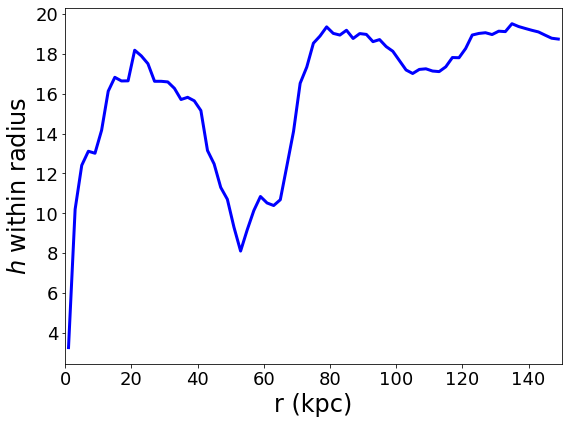

In [38]:
fontsize = 24
fig = plt.figure(figsize=(8,6))
plt.plot(radii, norm(h, axis=1), 'b-', lw=3)
plt.xlabel('r (kpc)', fontsize=fontsize)
plt.ylabel('$h$ within radius', fontsize=fontsize)
plt.xlim(0, 150)

plt.tight_layout()
plt.savefig('rem_h_r.pdf', rasterized=True, dpi=350);

Here, $\phi$ is the angle in the $x,y$ plane, $\theta$ is the angle downwards from the positive $z$-axis. 

In [39]:
L_hat = L / norm(L, axis=1)[:,np.newaxis]
phi = np.arctan2(L_hat[:,1], L_hat[:,0]) * 180/np.pi
theta = np.arccos(L_hat[:,2]) * 180/np.pi

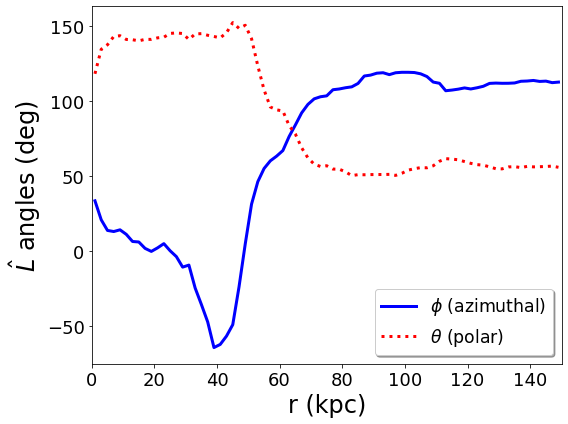

In [40]:
fontsize = 24
fig = plt.figure(figsize=(8,6))
plt.plot(radii, phi, 'b-', lw=3, label=r'$\phi$ (azimuthal)')
plt.plot(radii, theta, 'r:', lw=3, label=r'$\theta$ (polar)')
plt.xlabel('r (kpc)', fontsize=fontsize)
plt.ylabel('$\hat{L}$ angles (deg)', fontsize=fontsize)
plt.xlim(0, 150)

plt.legend(loc='lower right', fontsize='xx-large', shadow=True)
plt.tight_layout()
plt.savefig('rem_phi_theta.pdf', rasterized=True, dpi=350);

### Halo angular momentum

Get just the DM particles (type=1) for the remnant at the last time point:

In [41]:
remn_halo = np.where(full_remnant.data['type']==1)

In [42]:
angmom_halo = sub_spec_angmom(m, xyz, vxyz, remn_halo)
angmom_halo_mag = norm(angmom_halo)
angmom_halo_unit = (angmom_halo/angmom_halo_mag).value
angmom_halo_unit, angmom_halo_mag

(array([ 0.6442282 ,  0.03302421, -0.76412   ], dtype=float32),
 <Quantity 13.14736 kpc2 / Myr>)

#### Halo time course

In [43]:
def halo_angmom(m, xyz, vxyz):
    L = np.sum(np.cross(xyz, m*vxyz, axis=0), axis=1)
    h = L / np.sum(m)

    return h.to(u.kpc**2/u.Myr)

In [44]:
def galaxy_halo_angmom(gal, snap):
    g = Galaxy(gal, snap=snap, ptype=1, usesql=True)
    com_xyz, com_vxyz = tc.get_one_com(gal, snap)
    xyz = (g.xyz() - com_xyz[:, np.newaxis]) * u.kpc
    vxyz = (g.vxyz() - com_vxyz[:, np.newaxis]) * u.km/u.s
    m = g.data['m']
    h = halo_angmom(m, xyz, vxyz)
    halo_mag = norm(h)
    halo_unit = (h/halo_mag).value
    return halo_unit, halo_mag

Write all values to text file (slow!):

In [45]:
# with open('./halo_h.txt', 'w') as f:
#     f.write(f"# {'gal':>5s}{'snap':>8s}{'t':>8s}{'h_x':>8s}{'h_y':>8s}{'h_z':>8s}{'h_mag':>8s}\n")
    
# for galname in ('MW','M31','M33'):
#     print(galname)
#     for snap in np.arange(0, 802):
#         t = tc.snap2time(snap)
#         (hx, hy, hz), h_mag = galaxy_halo_angmom(galname, snap)
#         with open('./halo_h.txt', 'a') as f:
#             f.write(f"{galname:>7s}{snap:8d}{t:8.3f}{hx:8.2f}{hy:8.2f}{hz:8.2f}{h_mag.value:8.3f}\n")   

Read the data back in and plot it:

In [46]:
halo_h = np.genfromtxt('halo_h.txt', names=True, skip_header=0,
                    dtype=[('gal', 'U3'), ('snap', '<i8'), ('t', '<f8'), ('h_x', '<f8'), 
                           ('h_y', '<f8'), ('h_z', '<f8'), ('h_mag', '<f8')])

In [47]:
MW = halo_h[halo_h['gal'] == 'MW']
M31 = halo_h[halo_h['gal'] == 'M31']
M33 = halo_h[halo_h['gal'] == 'M33']

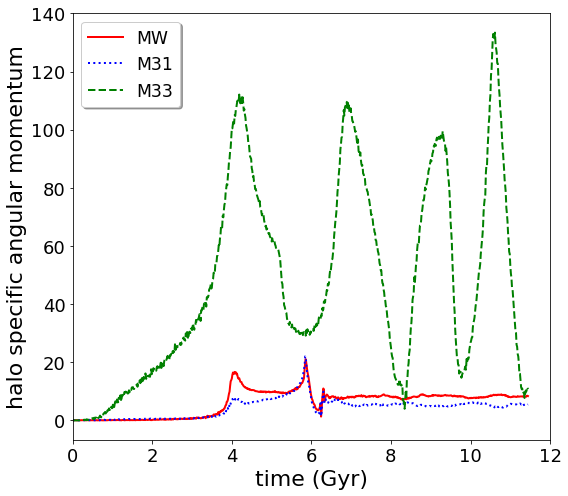

In [48]:
fig = plt.figure(figsize=(8,7))
ax0 = plt.subplot()

# add the curves
n = 1 # plot every n'th time point
ax0.plot(MW['t'][::n], MW['h_mag'][::n], 'r-', lw=2, label='MW')
ax0.plot(M31['t'][::n], M31['h_mag'][::n], 'b:', lw=2, label='M31')
ax0.plot(M33['t'][::n], M33['h_mag'][::n], 'g--', lw=2, label='M33')

ax0.legend(fontsize='xx-large', shadow=True)

# Add axis labels
ax0.set_xlabel("time (Gyr)", fontsize=22)
ax0.set_ylabel("halo specific angular momentum", fontsize=22)

ax0.set_xlim(0,12)
# ax0.set_ylim(0,6)

# ax0.set_title("Hernquist scale radius", fontsize=24)
#adjust tick label font size
label_size = 22
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

plt.tight_layout()
plt.savefig('halo_h.pdf', rasterized=True, dpi=350);

### Spin parameter $\lambda$

In [49]:
def halo_L(m, xyz, vxyz):
#     print(m.shape, xyz.shape, vxyz.shape)
    L = np.sum(np.cross(xyz, m*vxyz, axis=0), axis=1)
#     print(L.shape)

    return L.to(u.Msun * u.kpc**2/u.Myr)

In [50]:
def remnant_halo_data(snap):
    # some objects
    rem = Remnant(snap=snap, ptype=(1,2,3), usesql=True)
    com = CenterOfMass(rem)
    mp = MassProfile(rem)
    
    # find CoM for disk particles
    com_xyz = com.com_p()
    com_vxyz = com.com_v(com_xyz)
    
    # center coordinates
    xyz = rem.xyz() * u.kpc - com_xyz[:, np.newaxis]
    vxyz = rem.vxyz() * u.km/u.s - com_vxyz[:, np.newaxis]
    
    # mass and distance from CoM
    m = rem.data['m'] * 1e10 * u.Msun
    r = norm(xyz, axis=0)
    
    # virial radius (using current rho_c)
    r_200 = mp.virial_radius()
    
    # we just want DM particles inside r_200
    wanted = np.where((rem.data['type'] == 1) & (r.value < r_200))
    m_dm = m[wanted]
    xyz_dm = xyz.T[wanted].T
    vxyz_dm = vxyz.T[wanted].T
    r_dm = r[wanted]
    
    # angular momentum
    L = halo_L(m_dm, xyz_dm, vxyz_dm)
    L_mag = norm(L)
    L_unit = (L/L_mag).value
    
    # kinetic energy
    v = norm(vxyz_dm)
    K = np.sum(m_dm * v**2) / 2
    
    # halo mass
    M = np.sum(m_dm)
    
    return L_unit, L_mag, K, M

In [51]:
# with open('./halo_L.txt', 'w') as fL:
#     fL.write(f"# {'snap':>8s}{'t':>8s}{'L_x':>8s}{'L_y':>8s}{'L_z':>8s}{'L_mag':>10s}\n")
    
# with open('./halo_K.txt', 'w') as fK:
#     fK.write(f"# {'snap':>8s}{'t':>8s}{'K':>10s}{'m_200':>12s}\n")
    
# for snap in np.arange(440, 802):
#     t = tc.snap2time(snap)
#     (Lx, Ly, Lz), L_mag, K, M = remnant_halo_data(snap)
#     with open('./halo_L.txt', 'a') as fL:
#         fL.write(f"{snap:10d}{t:8.3f}{Lx:8.2f}{Ly:8.2f}{Lz:8.2f}{L_mag.value:12.3e}\n")   
#     with open('./halo_K.txt', 'a') as fK:
#         fK.write(f"{snap:10d}{t:8.3f}{K.value:12.3e}{M.value:12.3e}\n")           

In [52]:
rem_halo_L = np.genfromtxt('halo_L.txt', names=True, skip_header=0,
                    dtype=[('snap', '<i8'), ('t', '<f8'), ('L_x', '<f8'), 
                           ('L_y', '<f8'), ('L_z', '<f8'), ('L_mag', '<f8')])

In [53]:
rem_halo_K = np.genfromtxt('halo_K.txt', names=True, skip_header=0,
                    dtype=[('snap', '<i8'), ('t', '<f8'), ('K', '<f8'), ('M', '<f8')])

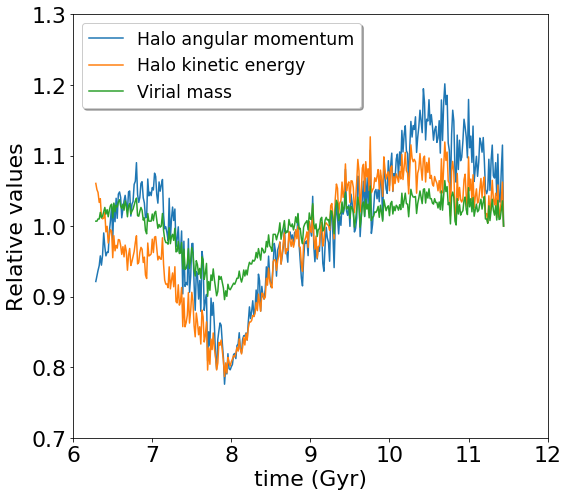

In [54]:
fig = plt.figure(figsize=(8,7))
plt.plot(rem_halo_L['t'], rem_halo_L['L_mag']/rem_halo_L['L_mag'][-1], 
         label='Halo angular momentum')
plt.plot(rem_halo_K['t'], rem_halo_K['K']/rem_halo_K['K'][-1], 
         label='Halo kinetic energy')
plt.plot(rem_halo_K['t'], rem_halo_K['m_200']/rem_halo_K['m_200'][-1], 
         label='Virial mass')
plt.legend(fontsize='xx-large', shadow=True)

# Add axis labels
plt.xlabel("time (Gyr)", fontsize=22)
plt.ylabel("Relative values", fontsize=22)

plt.xlim(6,12)
plt.ylim(0.7,1.3)

# ax0.set_title("Hernquist scale radius", fontsize=24)
#adjust tick label font size
label_size = 22
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

plt.tight_layout()
plt.savefig('halo_data.pdf', rasterized=True, dpi=350);

In [55]:
L_unit, L_mag, K, M = remnant_halo_data(801)

In [56]:
L_unit, L_mag, K, M

(array([ 0.6170189 ,  0.16175665, -0.7701444 ], dtype=float32),
 <Quantity 2.8918735e+12 kpc2 solMass / Myr>,
 <Quantity 7.50165153e+21 km2 solMass / s2>,
 <Quantity 1.286026e+12 solMass>)

In [57]:
from astropy.constants import G
G = G.to(u.kpc**2/ u.Msun / u.Myr * u.km / u.s)

In [58]:
lambd = L_mag * np.sqrt(K) / (G * M**2.5)
lambd

<Quantity 30.36119244>

In [59]:
K.to(u.erg)

<Quantity 1.49163579e+65 erg>

## Velocity dispersion